# UA Q1 time of flight

runs the UA Q1 time of flight
we check
1. the RF_in gain is good (single run signal falls within +-0.5V
2. the global time of light (delay between RO input and digitizer)
3. the I, Q offset for the readout

In [1]:
# set up non-QM hardware
import Labber
# connect to server 
client = Labber.connectToServer('localhost') # get list of instruments 
#instruments = client.getListOfInstrumentsString() 
#for instr in instruments: 
#    print(instr) # close connection 

# reset all QDevil channels to 0 V
QDevil = client.connectToInstrument('QDevil QDAC', dict(interface='Serial', address='3'))
for n in range(24):
    if n+1 < 10:
        QDevil.setValue("CH0" + str(n+1) + " Voltage", 0.0)
    else:
        QDevil.setValue("CH" + str(n+1) + " Voltage", 0.0)
# setting CH01 to sweet spot
DC_ss = -0.158888
QDevil.setValue("CH01 Voltage", DC_ss)

# Set other qubits at the antinode
QDevil.setValue("CH02 Voltage", 0.6)
QDevil.setValue("CH03 Voltage", 2.9)
QDevil.setValue("CH04 Voltage", 3.4)

# digital attenuators
Vaunix1 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25606'))
Vaunix2 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25607'))
ROI = 32
ROO = 10
Vaunix1.setValue("Attenuation", ROI)
Vaunix2.setValue("Attenuation", ROO)

# TWPA pump
SG = client.connectToInstrument('Rohde&Schwarz RF Source', dict(interface='TCPIP', address='192.168.88.2'))
freq_TWPA = 6326E6;
pwr_TWPA = -10;
SG.setValue('Frequency', freq_TWPA)
SG.setValue('Power', pwr_TWPA)

client.close()

In [2]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from configuration import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
import qdac as qdac
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
import datetime 
import os
import time
import warnings

warnings.filterwarnings("ignore")

2023-09-06 11:27:43,983 - qm - INFO     - Starting session: 1e2b9dfd-c7b7-4b71-8929-68f56652d00b


In [8]:
now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

tPath = os.path.join(r'Z:\LabberData_DF5\QM_Data_DF5',year,month,'Data_'+month+day)
if not os.path.exists(tPath):
   os.makedirs(tPath)

exp_name = 'Time_of_flight'
qubit_name = 'UA_Q1'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str + '.mat'
json_name = f_str + '_state.json'

machine = QuAM("quam_state.json")
# machine.resonators[0].readout_pulse_amp = 0.27
# machine.global_parameters.time_of_flight = 300
# machine.global_parameters.con1_downconversion_offset_I = -0.009494+0.014570+0.005617+0.000132+0.000143
# machine.global_parameters.con1_downconversion_offset_Q = -0.012887+0.019645+0.008021+0.000262
config = build_config(machine)

qubit_index = 0

n_avg = 1000  # Number of averaging loops
cooldown_time = 20_000 # convert to ns in the wait function!

with program() as raw_trace_prog:
    n = declare(int)
    adc_st = declare_stream(adc_trace=True)

    with for_(n, 0, n < n_avg, n + 1):
        reset_phase(machine.resonators[qubit_index].name)
        measure("readout", machine.resonators[qubit_index].name, adc_st)
        wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)

    with stream_processing():
        # Will save average:
        adc_st.input1().average().save("adc1")
        adc_st.input2().average().save("adc2")
        adc_st.input1().save("adc1_single_run")
        adc_st.input2().save("adc2_single_run")

#  Open Communication with the QOP  #
qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)

qm = qmm.open_qm(config)
job = qm.execute(raw_trace_prog)
res_handles = job.result_handles
res_handles.wait_for_all_values()
adc1 = u.raw2volts(res_handles.get("adc1").fetch_all())
adc2 = u.raw2volts(res_handles.get("adc2").fetch_all())
adc1_single_run = u.raw2volts(res_handles.get("adc1_single_run").fetch_all())
adc2_single_run = u.raw2volts(res_handles.get("adc2_single_run").fetch_all())

adc1_mean = np.mean(adc1)
adc2_mean = np.mean(adc2)
adc1_unbiased = adc1 - np.mean(adc1)
adc2_unbiased = adc2 - np.mean(adc2)
signal = savgol_filter(np.abs(adc1_unbiased + 1j * adc2_unbiased), 11, 3)
# detect arrival of readout signal
th = (np.mean(signal[:100]) + np.mean(signal[:-100])) / 2
delay = np.where(signal > th)[0][0]
delay = np.round(delay / 4) * 4
dc_offset_i = -adc1_mean
dc_offset_q = -adc2_mean

2023-09-06 11:30:33,445 - qm - ERROR    - Encountered connection error from QOP
Traceback (most recent call last):
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\base_api.py", line 27, in wrapped
    return func(*args, **kwargs)
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\frontend_api.py", line 79, in get_version
    response = run_async(self._stub.get_version(Empty(), timeout=self._timeout))
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\utils\async_utils.py", line 37, in run_async
    return create_future(coroutine).result()  # type: ignore[no-any-return]
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 444, in result
    return self.__get_result()
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 389, in __get_result
    raise self._exception
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\

ERROR:qm.api.base_api:Encountered connection error from QOP
Traceback (most recent call last):
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\base_api.py", line 27, in wrapped
    return func(*args, **kwargs)
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\frontend_api.py", line 79, in get_version
    response = run_async(self._stub.get_version(Empty(), timeout=self._timeout))
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\utils\async_utils.py", line 37, in run_async
    return create_future(coroutine).result()  # type: ignore[no-any-return]
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 444, in result
    return self.__get_result()
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 389, in __get_result
    raise self._exception
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\grpc\frontend\__i

2023-09-06 11:30:33,568 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-09-06 11:30:33,582 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-09-06 11:30:34,613 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-09-06 11:30:34,818 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


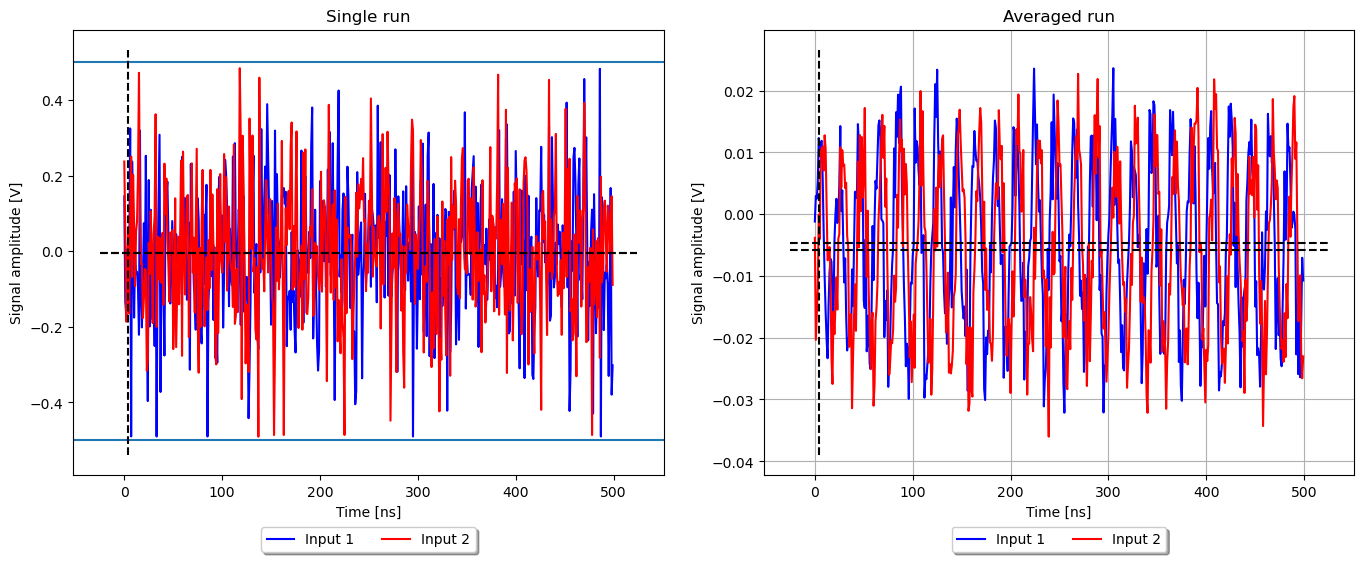

DC offset to add to I: 0.004679 V
DC offset to add to Q: 0.005816 V
TOF to add: 4.0 ns


In [9]:
# Plot data
fig = plt.figure(figsize=[14, 6])
# plt.rcParams['figure.figsize'] = [12, 8]
plt.subplot(121)
plt.title("Single run")
plt.plot(adc1_single_run, "b", label="Input 1")
plt.plot(adc2_single_run, "r", label="Input 2")
plt.axhline(y=0.5)
plt.axhline(y=-0.5)
xl = plt.xlim()
yl = plt.ylim()
plt.plot(xl, adc1_mean * np.ones(2), "k--")
plt.plot(xl, adc2_mean * np.ones(2), "k--")
plt.plot(delay * np.ones(2), yl, "k--")
plt.xlabel("Time [ns]")
plt.ylabel("Signal amplitude [V]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.subplot(122)
plt.title("Averaged run")
plt.plot(adc1, "b", label="Input 1")
plt.plot(adc2, "r", label="Input 2")
plt.xlabel("Time [ns]")
plt.ylabel("Signal amplitude [V]")
xl = plt.xlim()
yl = plt.ylim()
# plt.axhline(y=0.5)
# plt.axhline(y=-0.5)
plt.plot(xl, adc1_mean * np.ones(2), "k--")
plt.plot(xl, adc2_mean * np.ones(2), "k--")
plt.plot(delay * np.ones(2), yl, "k--")
plt.xlabel("Time [ns]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.grid("all")
plt.tight_layout(pad=2)
plt.show()

# Update the config
print(f"DC offset to add to I: {dc_offset_i:.6f} V")
print(f"DC offset to add to Q: {dc_offset_q:.6f} V")
print(f"TOF to add: {delay} ns")

In [6]:
machine.global_parameters.time_of_flight = 304
machine.global_parameters.con1_downconversion_offset_I += 0.009985
machine.global_parameters.con1_downconversion_offset_Q += 0.013658

In [10]:
machine._save("quam_state.json", flat_data=False)

In [12]:
savemat(os.path.join(tPath, file_name), {"adc1": adc1, "adc2": adc2, "adc1_single_run": adc1_single_run, "adc1_single_run": 0, "adc2_single_run": adc2_single_run, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)